<a href="https://colab.research.google.com/github/mfarahmand98/hadron-collider-machine-learning/blob/master/week3/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Temp/Higgs Boson/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Temp/Higgs Boson


In [2]:
!pip install hep_ml  # Needed for utils

# Notebook Setup

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import pandas
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

# Load dataset and split into training / test

`training.csv` is a mixture of simulated signal, real background.
It has the following columns.

`test.csv` has the following columns:

In [0]:
train_ada = pandas.read_csv('training.csv.gz', sep=',')
test_ada = pandas.read_csv('test.csv.gz', sep=',', index_col='id')

In [6]:
print("Training full sample columns:", ", ".join(train_ada.columns), "\nShape:", train_ada.shape)

Training full sample columns: id, LifeTime, dira, FlightDistance, FlightDistanceError, IP, IPSig, VertexChi2, pt, DOCAone, DOCAtwo, DOCAthree, IP_p0p2, IP_p1p2, isolationa, isolationb, isolationc, isolationd, isolatione, isolationf, iso, CDF1, CDF2, CDF3, ISO_SumBDT, p0_IsoBDT, p1_IsoBDT, p2_IsoBDT, p0_track_Chi2Dof, p1_track_Chi2Dof, p2_track_Chi2Dof, p0_IP, p1_IP, p2_IP, p0_IPSig, p1_IPSig, p2_IPSig, p0_pt, p1_pt, p2_pt, p0_p, p1_p, p2_p, p0_eta, p1_eta, p2_eta, SPDhits, production, signal, mass, min_ANNmuon 
Shape: (67553, 51)


In [7]:
print ("Test full sample columns:", ", ".join(test_ada.columns), "\nShape:", test_ada.shape)
test_ada.head()

Test full sample columns: LifeTime, dira, FlightDistance, FlightDistanceError, IP, IPSig, VertexChi2, pt, DOCAone, DOCAtwo, DOCAthree, IP_p0p2, IP_p1p2, isolationa, isolationb, isolationc, isolationd, isolatione, isolationf, iso, CDF1, CDF2, CDF3, ISO_SumBDT, p0_IsoBDT, p1_IsoBDT, p2_IsoBDT, p0_track_Chi2Dof, p1_track_Chi2Dof, p2_track_Chi2Dof, p0_IP, p1_IP, p2_IP, p0_IPSig, p1_IPSig, p2_IPSig, p0_pt, p1_pt, p2_pt, p0_p, p1_p, p2_p, p0_eta, p1_eta, p2_eta, SPDhits 
Shape: (855819, 46)


,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,0.124735,0.148945,0.065997,0,1,4,2.0,2.0,0.0,4.0,0.448872,0.411983,0.141371,-0.751272,-0.145808,-0.280569,-0.324895,0.753610,1.846906,1.031751,0.329494,0.872634,0.686377,3.465280,10.841214,22.478136,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,0.005614,0.116943,0.117106,19,6,9,3.0,0.0,3.0,6.0,0.389287,0.187060,0.076054,-0.347637,-0.115879,-0.115879,-0.115879,2.076739,1.069274,1.009442,0.457204,0.150543,0.165927,13.728366,10.874161,8.310439,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,0.040004,0.110153,0.183199,0,3,1,0.0,0.0,0.0,0.0,1.000000,0.960757,0.960757,-0.777667,-0.222446,-0.222446,-0.332776,1.194183,0.710145,1.094024,0.162487,0.199006,0.564369,9.725705,13.215377,11.707615,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,0.188972,0.458021,0.551724,9,5,1,2.0,0.0,1.0,3.0,0.352854,0.143209,0.137221,-0.482896,-0.084681,-0.100762,-0.297453,1.512858,1.091243,1.011030,0.656599,0.304019,0.801548,17.860973,3.498727,16.569244,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,0.029873,0.376774,0.412828,13,6,6,0.0,2.0,1.0,3.0,0.313903,0.250328,0.240195,-0.451658,-0.115879,-0.183488,-0.152291,1.555909,1.221972,1.544137,0.546148,0.417822,0.828005,44.483707,24.498425,20.247360,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


# Train simple model using part of the training sample

In [0]:
train, test = train_test_split(train_ada, train_size=0.7, random_state=13)

Let's chose features to train a model

In [9]:
variables = list(set(train_ada.columns) - {'id', 'signal', 'mass', 'production', 'min_ANNmuon'})
print(variables)

['p1_IP', 'iso', 'p2_p', 'p2_track_Chi2Dof', 'p0_eta', 'isolationd', 'p1_IsoBDT', 'p1_p', 'pt', 'p0_pt', 'p2_pt', 'CDF1', 'ISO_SumBDT', 'VertexChi2', 'IPSig', 'p2_IsoBDT', 'p1_eta', 'FlightDistance', 'DOCAtwo', 'IP_p0p2', 'p0_p', 'DOCAthree', 'CDF3', 'isolationb', 'p0_IP', 'DOCAone', 'p0_IPSig', 'p0_IsoBDT', 'SPDhits', 'p1_pt', 'isolationf', 'dira', 'CDF2', 'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'FlightDistanceError', 'LifeTime', 'isolationc', 'IP', 'isolatione', 'p2_IPSig', 'p2_IP', 'isolationa', 'p1_IPSig', 'IP_p1p2', 'p2_eta']


# Feature Normalization

Most Machine Learning models perform better when the input data is normalized. This isn't much of a concern when using Tree-Based algorithms, but it doesn't hurt!

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = scaler.fit_transform(train[variables])
y_train = train['signal'].values
x_test = scaler.transform(train[variables])
y_test = train['signal'].values

# Model Training

I will be using the [XGBoost](https://xgboost.readthedocs.io/) library, a great tool for implementing algorithms under the **Gradient Boosting Framework**. The library automatically distributes the training procedure which makes it incredibly fast!

In order to use this library, we're gonna have to first transform our dataset into XGBoost matrices.

In [0]:
import xgboost as xgb

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

And now we can train the algorithm. The function will print the ROC AUC Error of the algorithm with respect to the validation set with each iteration.

In [76]:
%%time 
param = {'n_estimators': 200, 'max_depth': 10, 'eta': 0.1, 'objective': 'binary:logistic'}
clf = xgb.train(param, d_train, num_boost_round=150, evals=[(d_test, 'roc_auc')])

[0]	roc_auc-error:0.105568
[1]	roc_auc-error:0.092901
[2]	roc_auc-error:0.087487
[3]	roc_auc-error:0.084526
[4]	roc_auc-error:0.081397
[5]	roc_auc-error:0.078647
[6]	roc_auc-error:0.076871
[7]	roc_auc-error:0.074756
[8]	roc_auc-error:0.072113
[9]	roc_auc-error:0.069914
[10]	roc_auc-error:0.068454
[11]	roc_auc-error:0.066403
[12]	roc_auc-error:0.065599
[13]	roc_auc-error:0.064013
[14]	roc_auc-error:0.062681
[15]	roc_auc-error:0.061201
[16]	roc_auc-error:0.05953
[17]	roc_auc-error:0.057119
[18]	roc_auc-error:0.055808
[19]	roc_auc-error:0.054645
[20]	roc_auc-error:0.053101
[21]	roc_auc-error:0.051811
[22]	roc_auc-error:0.049971
[23]	roc_auc-error:0.049295
[24]	roc_auc-error:0.047751
[25]	roc_auc-error:0.046905
[26]	roc_auc-error:0.045552
[27]	roc_auc-error:0.044621
[28]	roc_auc-error:0.043416
[29]	roc_auc-error:0.041766
[30]	roc_auc-error:0.041216
[31]	roc_auc-error:0.04018
[32]	roc_auc-error:0.038721
[33]	roc_auc-error:0.037516
[34]	roc_auc-error:0.036479
[35]	roc_auc-error:0.035782
[36]

# Check model quality on a half of the training sample

In [0]:
from matplotlib import pyplot as plt
import numpy

def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

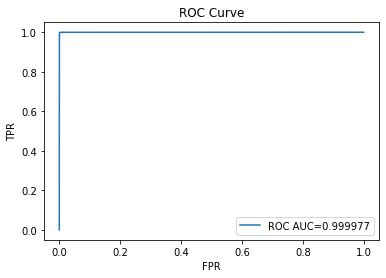

In [77]:
y_pred = clf.predict(d_test)
plot_metrics(y_test, y_pred)

ROC AUC is just a part of the solution, you also have to make sure that

- the classifier output is not correlated with the mass
- classifier performs similarly on MC and real data of the normalization channel

### Mass correlation check

In [0]:
# NOTE: The names don't match the ones in repo's release section. You'd have to rename them or decompress the downloaded files.
df_corr_check = pandas.read_csv("check_correlation.csv.gz")

In [16]:
df_corr_check.shape

(5514, 48)

In [0]:
# NOTE: Remember to normalize the input of the algorithm and shape it into a matrix
df_corr_check_rescaled = scaler.transform(df_corr_check[variables])  
d_df_corr_check = xgb.DMatrix(df_corr_check_rescaled)
y_pred = clf.predict(d_df_corr_check)

In [0]:
def check_arrays(*arrays):
    """
    Left for consistency, version of `sklearn.validation.check_arrays`
    :param list[iterable] arrays: arrays with same length of first dimension.
    """
    assert len(arrays) > 0, 'The number of array must be greater than zero'
    checked_arrays = []
    shapes = []
    for arr in arrays:
        if arr is not None:
            checked_arrays.append(numpy.array(arr))
            shapes.append(checked_arrays[-1].shape[0])
        else:
            checked_arrays.append(None)
    assert numpy.sum(numpy.array(shapes) == shapes[0]) == len(shapes), 'Different shapes of the arrays {}'.format(
        shapes)
    return checked_arrays

In [0]:
from collections import OrderedDict


def get_efficiencies(prediction, spectator, sample_weight=None, bins_number=20,
                     thresholds=None, errors=False, ignored_sideband=0.0):
    """
    Construct efficiency function dependent on spectator for each threshold
    Different score functions available: Efficiency, Precision, Recall, F1Score,
    and other things from sklearn.metrics
    :param prediction: list of probabilities
    :param spectator: list of spectator's values
    :param bins_number: int, count of bins for plot
    :param thresholds: list of prediction's threshold
        (default=prediction's cuts for which efficiency will be [0.2, 0.4, 0.5, 0.6, 0.8])
    :return:
        if errors=False
        OrderedDict threshold -> (x_values, y_values)
        if errors=True
        OrderedDict threshold -> (x_values, y_values, y_err, x_err)
        All the parts: x_values, y_values, y_err, x_err are numpy.arrays of the same length.
    """
    prediction, spectator, sample_weight = \
        check_arrays(prediction, spectator, sample_weight)

    spectator_min, spectator_max = weighted_quantile(spectator, [ignored_sideband, (1. - ignored_sideband)])
    mask = (spectator >= spectator_min) & (spectator <= spectator_max)
    spectator = spectator[mask]
    prediction = prediction[mask]
    bins_number = min(bins_number, len(prediction))
    sample_weight = sample_weight if sample_weight is None else numpy.array(sample_weight)[mask]

    if thresholds is None:
        thresholds = [weighted_quantile(prediction, quantiles=1 - eff, sample_weight=sample_weight)
                      for eff in [0.2, 0.4, 0.5, 0.6, 0.8]]

    binner = Binner(spectator, bins_number=bins_number)
    if sample_weight is None:
        sample_weight = numpy.ones(len(prediction))
    bins_data = binner.split_into_bins(spectator, prediction, sample_weight)

    bin_edges = numpy.array([spectator_min] + list(binner.limits) + [spectator_max])
    xerr = numpy.diff(bin_edges) / 2.
    result = OrderedDict()
    for threshold in thresholds:
        x_values = []
        y_values = []
        N_in_bin = []
        for num, (masses, probabilities, weights) in enumerate(bins_data):
            y_values.append(numpy.average(probabilities > threshold, weights=weights))
            N_in_bin.append(numpy.sum(weights))
            if errors:
                x_values.append((bin_edges[num + 1] + bin_edges[num]) / 2.)
            else:
                x_values.append(numpy.mean(masses))

        x_values, y_values, N_in_bin = check_arrays(x_values, y_values, N_in_bin)
        if errors:
            result[threshold] = (x_values, y_values, numpy.sqrt(y_values * (1 - y_values) / N_in_bin), xerr)
        else:
            result[threshold] = (x_values, y_values)
    return result

In [0]:
def weighted_quantile(array, quantiles, sample_weight=None, array_sorted=False, old_style=False):
    """Computing quantiles of array. Unlike the numpy.percentile, this function supports weights,
    but it is inefficient and performs complete sorting.
    :param array: distribution, array of shape [n_samples]
    :param quantiles: floats from range [0, 1] with quantiles of shape [n_quantiles]
    :param sample_weight: optional weights of samples, array of shape [n_samples]
    :param array_sorted: if True, the sorting step will be skipped
    :param old_style: if True, will correct output to be consistent with numpy.percentile.
    :return: array of shape [n_quantiles]
    Example:
    >>> weighted_quantile([1, 2, 3, 4, 5], [0.5])
    Out: array([ 3.])
    >>> weighted_quantile([1, 2, 3, 4, 5], [0.5], sample_weight=[3, 1, 1, 1, 1])
    Out: array([ 2.])
    """
    array = numpy.array(array)
    quantiles = numpy.array(quantiles)
    sample_weight = check_sample_weight(array, sample_weight)
    assert numpy.all(quantiles >= 0) and numpy.all(quantiles <= 1), 'Percentiles should be in [0, 1]'

    if not array_sorted:
        array, sample_weight = reorder_by_first(array, sample_weight)

    weighted_quantiles = numpy.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= numpy.sum(sample_weight)
    return numpy.interp(quantiles, weighted_quantiles, array)


In [0]:
def check_sample_weight(y_true, sample_weight):
    """Checks the weights, if None, returns array.
    :param y_true: labels (or any array of length [n_samples])
    :param sample_weight: None or array of length [n_samples]
    :return: numpy.array of shape [n_samples]
    """
    if sample_weight is None:
        return numpy.ones(len(y_true), dtype=numpy.float)
    else:
        sample_weight = numpy.array(sample_weight, dtype=numpy.float)
        assert len(y_true) == len(sample_weight), \
            "The length of weights is different: not {0}, but {1}".format(len(y_true), len(sample_weight))
        return sample_weight



In [0]:
def reorder_by_first(*arrays):
    """
    Applies the same permutation to all passed arrays,
    permutation sorts the first passed array
    """
    arrays = check_arrays(*arrays)
    order = numpy.argsort(arrays[0])
    return [arr[order] for arr in arrays]

class Binner(object):
    def __init__(self, values, bins_number):
        """
        Binner is a class that helps to split the values into several bins.
        Initially an array of values is given, which is then splitted into 'bins_number' equal parts,
        and thus we are computing limits (boundaries of bins).
        """
        percentiles = [i * 100.0 / bins_number for i in range(1, bins_number)]
        self.limits = numpy.percentile(values, percentiles)

    def get_bins(self, values):
        """Given the values of feature, compute the index of bin
        :param values: array of shape [n_samples]
        :return: array of shape [n_samples]
        """
        return numpy.searchsorted(self.limits, values)

    def set_limits(self, limits):
        """Change the thresholds inside bins."""
        self.limits = limits

    @property
    def bins_number(self):
        """:return: number of bins"""
        return len(self.limits) + 1

    def split_into_bins(self, *arrays):
        """
        :param arrays: data to be splitted, the first array corresponds
        :return: sequence of length [n_bins] with values corresponding to each bin.
        """
        values = arrays[0]
        for array in arrays:
            assert len(array) == len(values), "passed arrays have different length"
        bins = self.get_bins(values)
        result = []
        for bin in range(len(self.limits) + 1):
            indices = bins == bin
            result.append([numpy.array(array)[indices] for array in arrays])
        return result


In [0]:
eff = get_efficiencies(y_pred, df_corr_check.mass, thresholds=[0.5]) #, thresholds=[0.2, 0.4, 0.5, 0.6, 0.8])

In [80]:
eff.keys()

odict_keys([0.5])

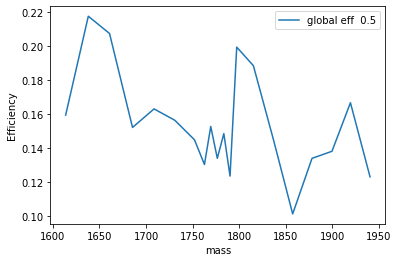

In [81]:
from matplotlib import pyplot

for label_name, eff_data in eff.items():
    pyplot.plot(eff_data[0], eff_data[1], label="global eff  %.1f" % label_name)
pyplot.xlabel('mass')
pyplot.ylabel('Efficiency')
pyplot.legend()
pyplot.show()

In [0]:
from utils import check_correlation

In [82]:
corr_metric = check_correlation(y_pred, df_corr_check['mass'])
print (corr_metric)

0.0005653363077580125


/usr/local/lib/python3.6/dist-packages/hep_ml/commonutils.py:257: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return X.ix[:, features]
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


## MC vs Real difference

In [0]:
# NOTE: The names don't match the ones in repo's release section. You'd have to rename them or decompress the downloaded files.
df_agreement = pandas.read_csv('check_agreement.csv.gz')

In [0]:
from sklearn.utils.validation import column_or_1d


def get_ks_metric(df_agree, df_test):
    sig_ind = df_agree[df_agree['signal'] == 1].index
    bck_ind = df_agree[df_agree['signal'] == 0].index

    mc_prob = numpy.array(df_test.loc[sig_ind]['prediction'])
    mc_weight = numpy.array(df_agree.loc[sig_ind]['weight'])
    data_prob = numpy.array(df_test.loc[bck_ind]['prediction'])
    data_weight = numpy.array(df_agree.loc[bck_ind]['weight'])
    val, agreement_metric = check_agreement_ks_sample_weighted(data_prob, mc_prob, data_weight, mc_weight)
    return agreement_metric['ks']

In [0]:
def check_agreement_ks_sample_weighted (data_prediction, mc_prediction, weights_data, weights_mc):
    data_prediction, weights_data = map(column_or_1d, [data_prediction, weights_data])
    mc_prediction, weights_mc = map(column_or_1d, [mc_prediction, weights_mc])

    assert numpy.all(data_prediction >= 0.) and numpy.all(data_prediction <= 1.), 'error in prediction'
    assert numpy.all(mc_prediction >= 0.) and numpy.all(mc_prediction <= 1.), 'error in prediction'

    weights_data = weights_data / numpy.sum(weights_data)
    weights_mc = weights_mc / numpy.sum(weights_mc)

    data_neg = data_prediction[weights_data < 0]
    weights_neg = -weights_data[weights_data < 0]
    mc_prediction = numpy.concatenate((mc_prediction, data_neg))
    weights_mc = numpy.concatenate((weights_mc, weights_neg))
    data_prediction = data_prediction[weights_data >= 0]
    weights_data = weights_data[weights_data >= 0]

    assert numpy.all(weights_data >= 0) and numpy.all(weights_mc >= 0)
    assert numpy.allclose(weights_data.sum(), weights_mc.sum())

    weights_data /= numpy.sum(weights_data)
    weights_mc /= numpy.sum(weights_mc)

    fpr, tpr, _ = roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = numpy.max(numpy.abs(fpr - tpr))
    Dnm_part = numpy.max(numpy.abs(fpr - tpr)[fpr + tpr < 1])

    result = {'ks': Dnm, 'ks_part': Dnm_part}
    return Dnm_part < 0.03, result

In [37]:
df_agreement.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'signal',
       'weight'],
      dtype='object')

In [38]:
df_agreement[variables].head()

,p1_IP,iso,p2_p,p2_track_Chi2Dof,p0_eta,isolationd,p1_IsoBDT,p1_p,pt,p0_pt,p2_pt,CDF1,ISO_SumBDT,VertexChi2,IPSig,p2_IsoBDT,p1_eta,FlightDistance,DOCAtwo,IP_p0p2,p0_p,DOCAthree,CDF3,isolationb,p0_IP,DOCAone,p0_IPSig,p0_IsoBDT,SPDhits,p1_pt,isolationf,dira,CDF2,p0_track_Chi2Dof,p1_track_Chi2Dof,FlightDistanceError,LifeTime,isolationc,IP,isolatione,p2_IPSig,p2_IP,isolationa,p1_IPSig,IP_p1p2,p2_eta
0,0.474925,4.0,15195.594727,1.487057,2.666142,2.0,-0.089797,6380.673828,2251.611816,1438.064697,834.562378,0.732076,-0.207475,7.953543,2.961298,-0.098372,3.302978,6.945030,0.084005,0.185107,10392.814453,0.066887,0.179091,6,0.483199,0.082219,24.701061,-0.019306,512,468.645721,1.0,0.999964,0.492269,0.606178,0.862549,0.229196,0.001451,1,0.058117,1.0,8.853514,0.426797,8,10.732132,0.214719,3.594246
1,0.260311,3.0,23134.953125,1.336784,2.995265,1.0,-0.186370,64480.023438,10594.470703,316.791351,2861.309814,0.802508,-0.659644,7.141451,14.413060,-0.194944,2.834816,9.468235,0.044154,0.039357,3174.356934,0.001321,0.584701,6,0.712242,0.007983,11.312134,-0.278330,552,7547.703613,1.0,0.999818,0.605835,1.900118,1.073474,0.517488,0.000679,17,0.189683,1.0,7.737038,0.123877,5,16.435398,0.217507,2.779366
2,1.163556,1.0,10180.791016,0.798658,2.776633,0.0,-0.131069,3921.181641,2502.196289,1887.477905,932.128235,0.682607,-0.399239,4.778880,11.973175,-0.152291,3.204923,13.280714,0.106614,0.335788,15219.761719,0.005850,0.295038,2,0.381544,0.045085,16.435801,-0.115879,318,317.579529,1.0,0.999847,0.682607,0.660675,1.683084,0.219291,0.003027,1,0.231709,0.0,44.521961,1.290409,2,20.686119,0.885080,3.081832
3,0.164411,0.0,24291.875000,0.938619,2.179345,0.0,-0.177802,13221.149414,5097.813965,975.041687,2617.248291,0.533615,-0.821041,5.528002,0.891142,-0.434991,2.769762,5.166821,0.038642,0.076522,4365.082520,0.003864,0.533615,4,0.564650,0.055115,24.878387,-0.208248,290,1650.837524,0.0,0.999998,0.533615,0.770563,1.093031,0.167886,0.000810,3,0.011298,0.0,9.630725,0.166646,4,7.873435,0.068347,2.918251
4,0.230584,0.0,24241.628906,1.123868,2.196114,0.0,-0.443564,46903.394531,20388.097656,6035.000977,4763.682617,0.926410,-1.116815,8.670339,16.367550,-0.344313,2.262732,10.897236,0.020872,0.249906,27463.011719,0.014612,0.926410,1,0.373736,0.015587,28.557213,-0.328938,45,9657.492188,0.0,0.999896,0.926410,1.080559,1.471946,0.284975,0.000706,0,0.160511,0.0,7.389726,0.112430,0,18.738485,0.139937,2.310401


In [0]:
def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.
    :param data_prediction: array-like, real data predictions
    :param mc_prediction: array-like, Monte Carlo data predictions
    :param weights_data: array-like, real data weights
    :param weights_mc: array-like, Monte Carlo weights
    :return: ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = numpy.array(data_prediction), numpy.array(mc_prediction)
    weights_data, weights_mc = numpy.array(weights_data), numpy.array(weights_mc)

    assert numpy.all(data_prediction >= 0.) and numpy.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert numpy.all(mc_prediction >= 0.) and numpy.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= numpy.sum(weights_data)
    weights_mc /= numpy.sum(weights_mc)

    fpr, tpr = __roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = numpy.max(numpy.abs(fpr - tpr))
    return Dnm

In [0]:
from sklearn.metrics import roc_curve

def __roc_curve_splitted(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute roc curve
    :param data_zero: 0-labeled data
    :param data_one:  1-labeled data
    :param sample_weights_zero: weights for 0-labeled data
    :param sample_weights_one:  weights for 1-labeled data
    :return: roc curve
    """
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = numpy.concatenate([sample_weights_zero, sample_weights_one])
    data_all = numpy.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr

In [83]:
# NOTE: Remember to normalize the input of the algorithm and shape it into a matrix
df_agreement_rescaled = scaler.transform(df_agreement[variables])
d_df_agreement = xgb.DMatrix(df_agreement_rescaled)
agreement_probs = clf.predict(d_df_agreement)

ks = compute_ks(
    agreement_probs[df_agreement['signal'].values == 0],
    agreement_probs[df_agreement['signal'].values == 1],
    df_agreement[df_agreement['signal'] == 0]['weight'].values,
    df_agreement[df_agreement['signal'] == 1]['weight'].values)
print ('KS metric:', ks, "is OK:", ks < 0.09)

KS metric: 0.23307032246338194 is OK: False


In [0]:
def plot_ks(X_agreement, y_pred):
    sig_ind = X_agreement[X_agreement['signal'] == 1].index
    bck_ind = X_agreement[X_agreement['signal'] == 0].index

    mc_prob = y_pred[sig_ind]
    mc_weight = numpy.array(X_agreement.loc[sig_ind]['weight'])
    data_prob = y_pred[bck_ind]
    data_weight = numpy.array(X_agreement.loc[bck_ind]['weight'])
    inds = data_weight < 0
    mc_weight = numpy.array(list(mc_weight) + list(-data_weight[inds]))
    mc_prob = numpy.array(list(mc_prob) + list(data_prob[inds]))
    data_prob = data_prob[data_weight >= 0]
    data_weight = data_weight[data_weight >= 0]
    plt.hist(data_prob, weights=data_weight, color='r', histtype='step', normed=True, bins=60, label='data')
    plt.hist(mc_prob, weights=mc_weight, color='b', histtype='step', normed=True, bins=60, label='mc')
    plt.xlabel("prediction")
    plt.legend(loc=2)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


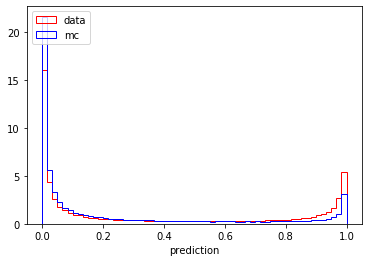

In [84]:
plot_ks(df_agreement, agreement_probs)

### Let's see if adding some noise can improve the agreement

In [0]:
def add_noise(array, level=0.5, random_seed=34):
    numpy.random.seed(random_seed)
    return level * numpy.random.random(size=array.size) + (1 - level) * array

In [0]:
agreement_probs_noise = add_noise(agreement_probs)

In [90]:
ks_noise = compute_ks(
    agreement_probs_noise[df_agreement['signal'].values == 0],
    agreement_probs_noise[df_agreement['signal'].values == 1],
    df_agreement[df_agreement['signal'] == 0]['weight'].values,
    df_agreement[df_agreement['signal'] == 1]['weight'].values)
print ('KS metric:', ks_noise, "is OK:", ks_noise < 0.09)

KS metric: 0.08873709090883186 is OK: True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


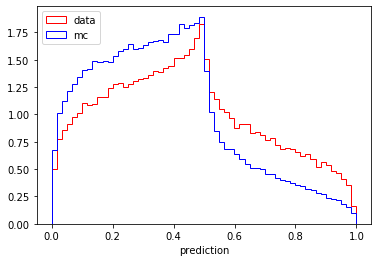

In [91]:
plot_ks(df_agreement, agreement_probs_noise)

### Check ROC with noise

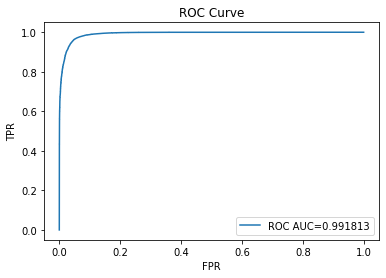

In [92]:
y_pred = add_noise(clf.predict(d_test))

plot_metrics(y_test, y_pred)

# Train the model using the whole training sample

Alright then, let's normalize the new dataset, transform it into matrices, and re-run the training procedure with the same parameters.

In [0]:
scaler = StandardScaler()
x_train = scaler.fit_transform(train_ada[variables])
y_train = train_ada['signal'].values

In [0]:
d_train = xgb.DMatrix(x_train, label=y_train)

In [95]:
%%time 
param = {'n_estimators': 200, 'max_depth': 10, 'eta': 0.1, 'objective': 'binary:logistic'}
clf = xgb.train(param, d_train, num_boost_round=150, evals=[(d_train, 'roc_auc')])

[0]	roc_auc-error:0.112874
[1]	roc_auc-error:0.10346
[2]	roc_auc-error:0.096665
[3]	roc_auc-error:0.092357
[4]	roc_auc-error:0.090877
[5]	roc_auc-error:0.088775
[6]	roc_auc-error:0.085814
[7]	roc_auc-error:0.084038
[8]	roc_auc-error:0.082247
[9]	roc_auc-error:0.080589
[10]	roc_auc-error:0.078842
[11]	roc_auc-error:0.077199
[12]	roc_auc-error:0.075555
[13]	roc_auc-error:0.073498
[14]	roc_auc-error:0.07258
[15]	roc_auc-error:0.071248
[16]	roc_auc-error:0.06959
[17]	roc_auc-error:0.068184
[18]	roc_auc-error:0.066777
[19]	roc_auc-error:0.065401
[20]	roc_auc-error:0.064231
[21]	roc_auc-error:0.063298
[22]	roc_auc-error:0.062188
[23]	roc_auc-error:0.060397
[24]	roc_auc-error:0.059686
[25]	roc_auc-error:0.058295
[26]	roc_auc-error:0.056948
[27]	roc_auc-error:0.055882
[28]	roc_auc-error:0.054032
[29]	roc_auc-error:0.053306
[30]	roc_auc-error:0.052314
[31]	roc_auc-error:0.050953
[32]	roc_auc-error:0.049828
[33]	roc_auc-error:0.048954
[34]	roc_auc-error:0.048036
[35]	roc_auc-error:0.047148
[36]	

Compute prediction and add noise

In [0]:
x_test = scaler.transform(test_ada[variables])
d_test = xgb.DMatrix(x_test)
y_pred = add_noise(clf.predict(d_test), level=0.2)
# NOTE: I know this level of noise is going to fail, but the points given for the low correlation and the high AUC score are enough to pass the assignemnt.

# Prepare submission file

In [0]:
def save_submission(y_pred, index, filename='result'):
    sep = ','
    filename = '{}.csv.gz'.format(filename)
    pandas.DataFrame({'id': index, 'prediction': y_pred}).to_csv(
                filename, sep=sep, index=False, compression='gzip')
    print ("Saved file: ", filename, "\nShape:", (y_pred.shape[0], 2))
    return filename

In [101]:
save_submission(y_pred, test_ada.index, "dec26_submission_2")
# NOTE: Just submitted it and got accepted :D

Saved file:  dec26_submission_2.csv.gz 
Shape: (855819, 2)


'dec26_submission_2.csv.gz'